In [1]:
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd

from apyori import apriori
from collections import Counter
from itertools import combinations

# for working with timestamps
from datetime import datetime
from dateutil.parser import parse

# for visualizations
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style="whitegrid")
import squarify
from  matplotlib.ticker import FuncFormatter

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df_aisles = pd.read_csv('../data/in/aisles.csv')
df_departments = pd.read_csv('../data/in/departments.csv')
df_products = pd.read_csv('../data/in/products.csv')
df_orders = pd.read_csv('../data/in/orders.csv')
df_order_products__prior = pd.read_csv('../data/in/order_products__prior.csv')
df_order_products__train = pd.read_csv('../data/in/order_products__train.csv')

In [3]:
df_aisles.head()
df_aisles.shape

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


(134, 2)

In [4]:
df_departments.head()
df_departments.shape

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


(21, 2)

In [5]:
df_products.head()
df_products.shape

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


(49688, 4)

In [6]:
df_merged = pd.merge(df_products,df_aisles,on='aisle_id')

In [7]:
df_merged.head()
df_merged.shape

,product_id,product_name,aisle_id,department_id,aisle
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes
2,102,Danish Butter Cookies,61,19,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes


(49688, 5)

In [8]:
df_merged = pd.merge(df_merged,df_departments,on='department_id')

In [9]:
df_merged.head()
df_merged.shape

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


(49688, 6)

In [10]:
def get_values(df, columns):
    """
    Takes a dataframe and a target column name and prints out the
    value counts of the specific column.

            Parameters:
                    df (dataframe): A pandas dataframe

            Returns:
                    null (NoneType):
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param) 

In [11]:
show_values(df_merged, ['department', 'aisle'])

department
personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: department, dtype: int64


aisle
missing                          1258
candy chocolate                  1246
ice cream ice                    1091
vitamins supplements             1038
yogurt                           1026
chips pretzels                    989
tea                               894
packaged cheese                   891
frozen meals                      880
cookies cakes                     874
energy granola bars               832
hair care                   

In [12]:
df_merged.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


In [13]:
df = df_merged[['department', 'aisle', 'product_name']]

In [14]:
df.head()
df.shape

,department,aisle,product_name
0,snacks,cookies cakes,Chocolate Sandwich Cookies
1,snacks,cookies cakes,Nutter Butter Cookie Bites Go-Pak
2,snacks,cookies cakes,Danish Butter Cookies
3,snacks,cookies cakes,Gluten Free All Natural Chocolate Chip Cookies
4,snacks,cookies cakes,Mini Nilla Wafers Munch Pack


(49688, 3)

In [15]:
def show_missing(df):
    """
    Takes a dataframe and a column and returns a dataframe of
    total missing values and percent missing values by column.

            Parameters:
                    df (dataframe): A pandas dataframe

            Returns:
                    dfx (dataframe): A list of cleaned words
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

In [16]:
show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
department,0,0.0,0,0.0,0,0.0
aisle,0,0.0,0,0.0,0,0.0
product_name,0,0.0,0,0.0,0,0.0


<Figure size 1152x432 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='department'>

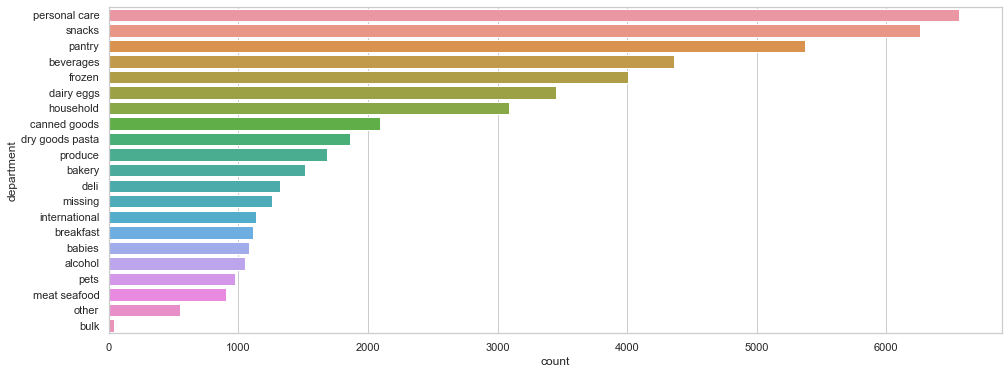

In [17]:
plt.figure(figsize=(16, 6))
sns.countplot(y=df['department'],order = df['department'].value_counts().index)

<Figure size 1152x432 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='aisle'>

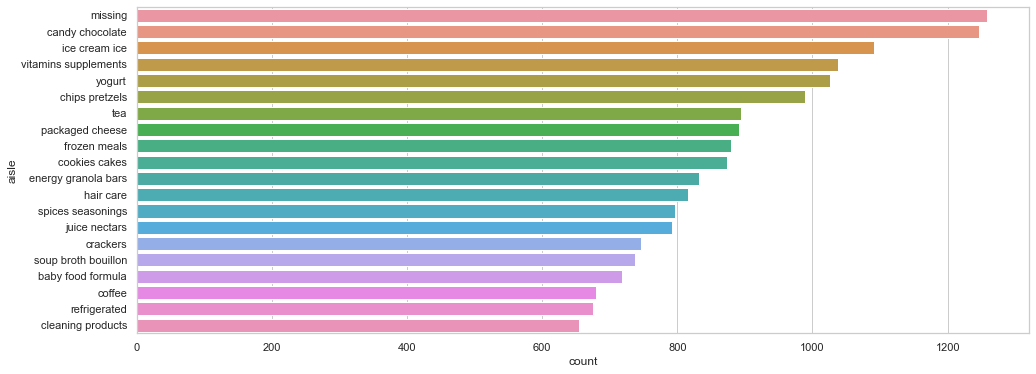

In [18]:
plt.figure(figsize=(16, 6))
sns.countplot(y=df['aisle'],order = df['aisle'].value_counts().nlargest(20).index)

In [19]:
aisle_list = df.groupby('department')[['aisle']].sum().index.get_level_values(0).tolist()

In [20]:
aisle_list

['alcohol',
 'babies',
 'bakery',
 'beverages',
 'breakfast',
 'bulk',
 'canned goods',
 'dairy eggs',
 'deli',
 'dry goods pasta',
 'frozen',
 'household',
 'international',
 'meat seafood',
 'missing',
 'other',
 'pantry',
 'personal care',
 'pets',
 'produce',
 'snacks']

In [21]:
volume_list = df.groupby('department')[['aisle']].count().reset_index().aisle.values.tolist()

In [22]:
volume_list

[1054,
 1081,
 1516,
 4365,
 1115,
 38,
 2092,
 3449,
 1322,
 1858,
 4007,
 3085,
 1139,
 907,
 1258,
 548,
 5371,
 6563,
 972,
 1684,
 6264]

<Figure size 1152x720 with 0 Axes>

<AxesSubplot:>

(0.0, 100.0, 0.0, 100.0)

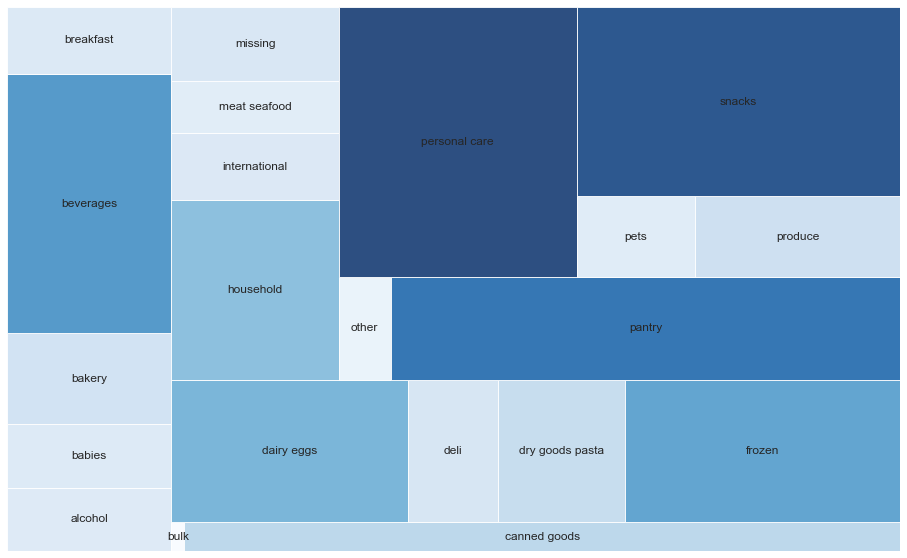

In [23]:
# create a color palette, mapped to these values
cmap = matplotlib.cm.Blues
mini=min(volume_list)
maxi=max(volume_list)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in volume_list]
 
plt.figure(figsize=(16,10)) 
squarify.plot(sizes=volume_list,label=aisle_list,alpha=0.85, color=colors )
plt.axis('off')

In [24]:
df_orders.head()
df_orders.shape

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


(3421083, 7)

In [25]:
df_order_products__prior.head()
df_order_products__prior.shape

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


(32434489, 4)

In [26]:
df_order_products__train.head()
df_order_products__train.shape

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


(1384617, 4)

In [27]:
show_missing(df_orders)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
order_id,0,0.000000,0,0.0,0,0.0
user_id,0,0.000000,0,0.0,0,0.0
eval_set,0,0.000000,0,0.0,0,0.0
order_number,0,0.000000,0,0.0,0,0.0
order_dow,0,0.000000,0,0.0,0,0.0
order_hour_of_day,0,0.000000,0,0.0,0,0.0
days_since_prior_order,206209,6.027594,0,0.0,0,0.0


In [28]:
df_orders['days_since_prior_order'] = df_orders['days_since_prior_order'].fillna(0) 

In [29]:
show_missing(df_orders)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
order_id,0,0.0,0,0.0,0,0.0
user_id,0,0.0,0,0.0,0,0.0
eval_set,0,0.0,0,0.0,0,0.0
order_number,0,0.0,0,0.0,0,0.0
order_dow,0,0.0,0,0.0,0,0.0
order_hour_of_day,0,0.0,0,0.0,0,0.0
days_since_prior_order,0,0.0,0,0.0,0,0.0


In [30]:
show_missing(df_order_products__prior)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
order_id,0,0.0,0,0.0,0,0.0
product_id,0,0.0,0,0.0,0,0.0
add_to_cart_order,0,0.0,0,0.0,0,0.0
reordered,0,0.0,0,0.0,0,0.0


In [31]:
show_missing(df_order_products__train)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
order_id,0,0.0,0,0.0,0,0.0
product_id,0,0.0,0,0.0,0,0.0
add_to_cart_order,0,0.0,0,0.0,0,0.0
reordered,0,0.0,0,0.0,0,0.0


<Figure size 1152x432 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='order_dow'>

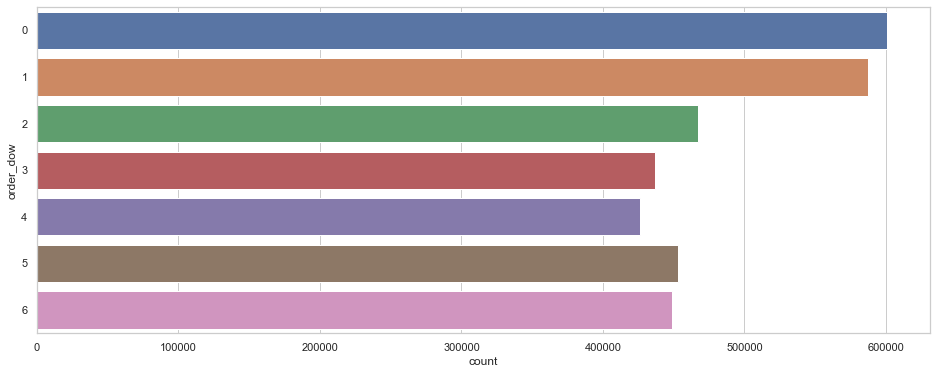

In [32]:
plt.figure(figsize=(16, 6))
sns.countplot(y = 'order_dow',data=df_orders)

<Figure size 1152x432 with 0 Axes>

c:\users\dd\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_hour_of_day', ylabel='Density'>

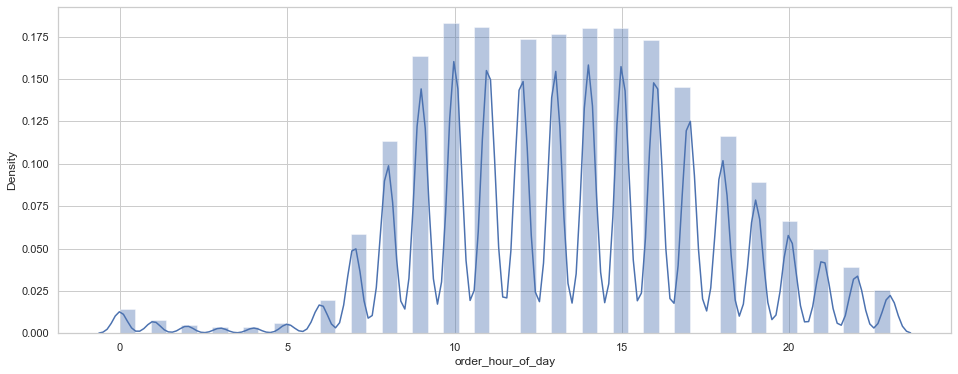

In [33]:
plt.figure(figsize=(16, 6))
sns.distplot(df_orders['order_hour_of_day'])

<Figure size 1152x432 with 0 Axes>

c:\users\dd\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

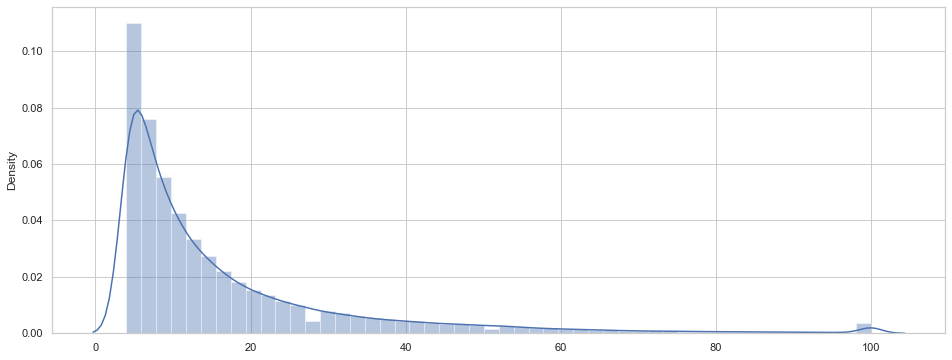

In [34]:
order_by_user = pd.DataFrame(df_orders.groupby('user_id')['order_number'].count())
plt.figure(figsize=(16, 6))
sns.distplot(order_by_user)

<Figure size 1152x432 with 0 Axes>

[Text(0, 0, '0.0'),
 Text(1, 0, '1.0'),
 Text(2, 0, '2.0'),
 Text(3, 0, '3.0'),
 Text(4, 0, '4.0'),
 Text(5, 0, '5.0'),
 Text(6, 0, '6.0'),
 Text(7, 0, '7.0'),
 Text(8, 0, '8.0'),
 Text(9, 0, '9.0'),
 Text(10, 0, '10.0'),
 Text(11, 0, '11.0'),
 Text(12, 0, '12.0'),
 Text(13, 0, '13.0'),
 Text(14, 0, '14.0'),
 Text(15, 0, '15.0'),
 Text(16, 0, '16.0'),
 Text(17, 0, '17.0'),
 Text(18, 0, '18.0'),
 Text(19, 0, '19.0'),
 Text(20, 0, '20.0'),
 Text(21, 0, '21.0'),
 Text(22, 0, '22.0'),
 Text(23, 0, '23.0'),
 Text(24, 0, '24.0'),
 Text(25, 0, '25.0'),
 Text(26, 0, '26.0'),
 Text(27, 0, '27.0'),
 Text(28, 0, '28.0'),
 Text(29, 0, '29.0'),
 Text(30, 0, '30.0')]

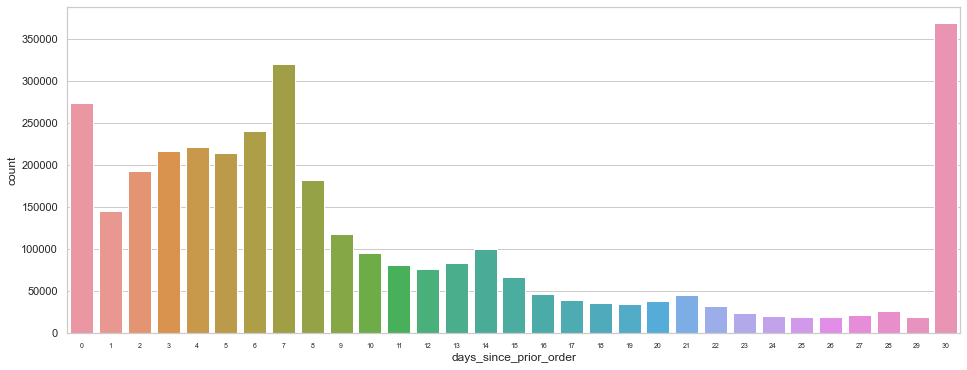

In [35]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x=df_orders['days_since_prior_order'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x))) 

In [36]:
df_orders['reorder_pattern'] = 'daily'
df_orders['reorder_pattern'][df_orders['days_since_prior_order'] <= 1] = 'daily'
df_orders['reorder_pattern'][(df_orders['days_since_prior_order'] > 1) & (df_orders['days_since_prior_order'] <= 7)]  = 'weekly'
df_orders['reorder_pattern'][(df_orders['days_since_prior_order'] > 7) & (df_orders['days_since_prior_order'] <= 15)]  = 'biweekly'
df_orders['reorder_pattern'][(df_orders['days_since_prior_order'] > 15) & (df_orders['days_since_prior_order'] <= 30)]  = 'monthly'

c:\users\dd\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\dd\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\dd\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

<Figure size 1152x432 with 0 Axes>

<AxesSubplot:xlabel='reorder_pattern', ylabel='count'>

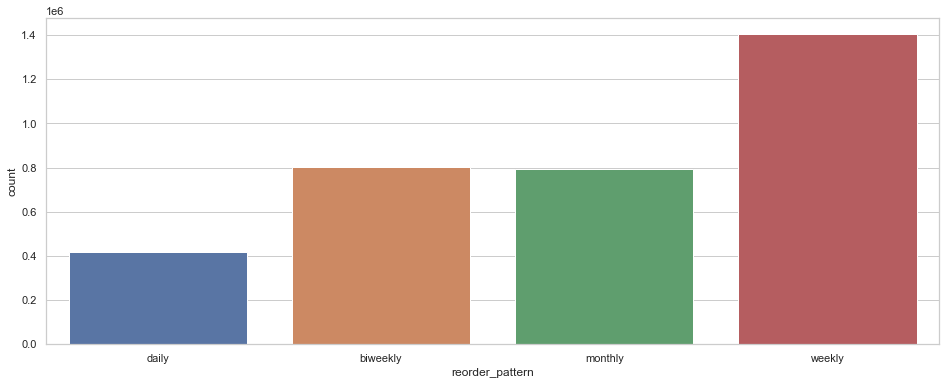

In [37]:
plt.figure(figsize=(16, 6))
sns.countplot(x=df_orders['reorder_pattern'])

In [38]:
df_order_products__prior['reordered'].value_counts()/len(df_order_products__prior['reordered'])

1    0.589697
0    0.410303
Name: reordered, dtype: float64

In [39]:
df_order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [40]:
df_priors = df_order_products__prior.merge(df_orders,on='order_id')

In [41]:
df_priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder_pattern
0,2,33120,1,1,202279,prior,3,5,9,8.0,biweekly
1,2,28985,2,1,202279,prior,3,5,9,8.0,biweekly
2,2,9327,3,0,202279,prior,3,5,9,8.0,biweekly
3,2,45918,4,1,202279,prior,3,5,9,8.0,biweekly
4,2,30035,5,0,202279,prior,3,5,9,8.0,biweekly


In [42]:
df_priors = df_priors.merge(df_products, on='product_id')

In [43]:
df_priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder_pattern,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,biweekly,Organic Egg Whites,86,16
1,26,33120,5,0,153404,prior,2,0,16,7.0,weekly,Organic Egg Whites,86,16
2,120,33120,13,0,23750,prior,11,6,8,10.0,biweekly,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,biweekly,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,biweekly,Organic Egg Whites,86,16


In [44]:
df_priors = df_priors[['order_id', 'reordered', 'reorder_pattern', 'product_name']]

In [45]:
df_priors.head()

,order_id,reordered,reorder_pattern,product_name
0,2,1,biweekly,Organic Egg Whites
1,26,0,weekly,Organic Egg Whites
2,120,0,biweekly,Organic Egg Whites
3,327,1,biweekly,Organic Egg Whites
4,390,1,biweekly,Organic Egg Whites


In [46]:
top_products = df_priors.product_name.value_counts().nlargest(20).reset_index()

<Figure size 1152x432 with 0 Axes>

<AxesSubplot:xlabel='product_name', ylabel='index'>

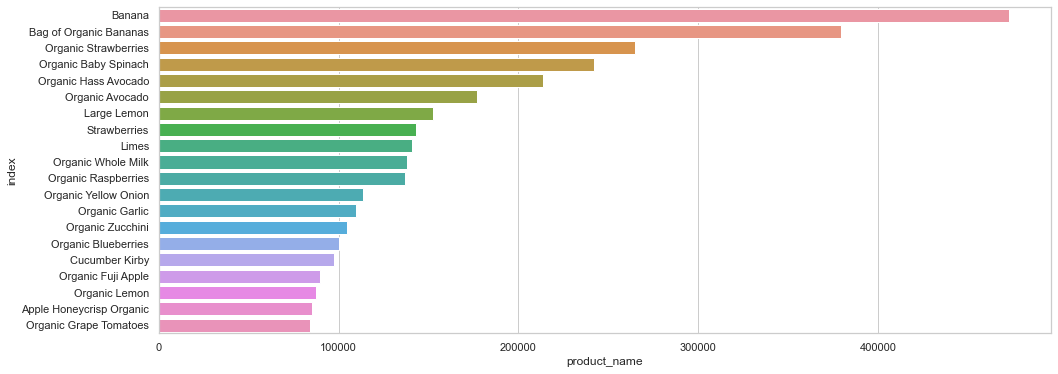

In [47]:
plt.figure(figsize=(16, 6))
sns.barplot(y=top_products['index'],x=top_products['product_name'])

In [48]:
df_priors = df_priors[df_priors['reordered']==1]

In [49]:
top_reordered = df_priors.product_name.value_counts().nlargest(20)
top_reordered = top_reordered.reset_index()

<Figure size 1152x432 with 0 Axes>

<AxesSubplot:xlabel='product_name', ylabel='index'>

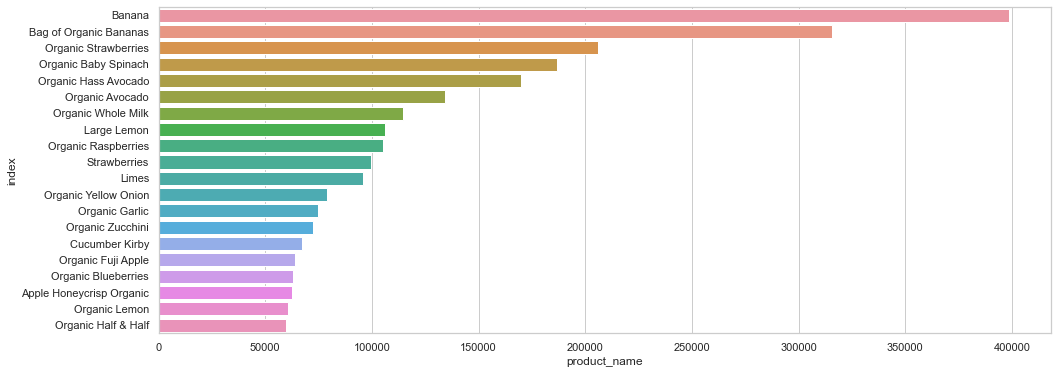

In [50]:
plt.figure(figsize=(16, 6))
sns.barplot(y=top_reordered['index'],x=top_reordered['product_name'])

In [51]:
df_priors.head()

,order_id,reordered,reorder_pattern,product_name
0,2,1,biweekly,Organic Egg Whites
3,327,1,biweekly,Organic Egg Whites
4,390,1,biweekly,Organic Egg Whites
5,537,1,weekly,Organic Egg Whites
6,582,1,biweekly,Organic Egg Whites


In [52]:
df_priors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19126536 entries, 0 to 32434456
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   order_id         int64 
 1   reordered        int64 
 2   reorder_pattern  object
 3   product_name     object
dtypes: int64(2), object(2)
memory usage: 729.6+ MB


In [53]:
dfx = df_priors.groupby(['order_id', 'product_name'])['reordered'].sum().unstack().reset_index().set_index('order_id')

ValueError: Unstacked DataFrame is too big, causing int32 overflow

In [ ]:
dfx.head()